In [1]:
%matplotlib inline
import numpy as np
import IPython.display as ipd
import math
import librosa
import librosa.display
import librosa.feature
import scipy.signal.windows
import matplotlib.pyplot as plt
                                    
# Geometric chirp
def geometric_chirp_point_frequency(t, f0, f1, T):
    k = np.power(f1 / f0, 1 / T)
    return f0 * np.power(k, t)

def geometric_chirp_phase(t, f0, f1, T, phi=0):
    # This is 2pi * integral of frequency
    k = np.power(f1 / f0, 1 / T)
    return phi + 2 * np.pi * f0 * (np.power(k, t)-1) / np.log(k)

# Mel chirp
def mel_to_hz(mel):
    return 700 * (np.exp(mel / 1127) - 1)

def hz_to_mel(f):
    #return 2595*np.log(1+f/700)/log(10)
    return 1127 * np.log(1 + f / 700)

def mel_chirp_point_frequency(t, m0, m1, T):
    k = (m1 - m0) / T
    return 700 * (np.exp((m0 + k * t) / 1127) - 1)

def mel_chirp_phase(t, m0, m1, T, phi=0):
    k = (m1 - m0) / T
    return phi + 2 * np.pi * (788900 * np.exp((m0 + k * t) / 1127) - k * t) / k

# Bark chirp
def hz_to_bark(f):
    #return 13*np.atan(f*0.00076)+3.5*np.atan(f*f/56250000)
    return 26.81*f/(f+1960)-0.53
    #return 6*np.arcsinh(f/600)

def bark_to_hz(bark):
    return 490*(100*bark+53)/(657-25*bark)

def bark_chirp_phase(t, b0, b1, T, phi=0):
    k = (b1-b0)/T
    return phi+2*np.pi*(
        98/(5*k) * (
            2681*np.log(657-25*(b0+k*t))
            +100*(b0+k*t)
            -2628
        )
    )

# Erbs chirp
def hz_to_erbs(f):
    return 21.4*np.log10(1+0.00437*f)

def erbs_to_hz(erbs):
    return (np.power(10,erbs/21.4)-1)/0.00437


# Erb chirp (probably doesn't make sense considering ERBS is about bandwidth)
def hz_to_erb(f):
    return 28.52+f*(93.39+f*(6.23))

def erb_to_hz(erb):
    return (np.sqrt(249200*erb+80109737)-9339)/1246

def erb_chirp_phase(r, e0, e1, T, phi=0):
    k = (e1-e0)/T
    return phi+2*np.pi*(
        np.power(
            249200*(e0+k*t)+80109737,
            1.5
        )/(465754800*k)
        -t*9339/1246
    )

In [2]:
fs = 44100 # Hz
f0 = 80 # Hz
f1 = 8000 # Hz
play_time = 3 # seconds
prf = 100 # Hz
chirp_len = 1 / prf # seconds

In [3]:
chirp_reps = math.ceil(play_time/chirp_len)
t = np.linspace(0, chirp_len, int(chirp_len * fs))

In [4]:
def spectrogram(y, sr):
    ps = librosa.feature.melspectrogram(y=y, sr=sr)
    ps_db= librosa.power_to_db(ps, ref=np.max)
    librosa.display.specshow(ps_db, x_axis='s', y_axis='log')

# Gaussian sweep across chirp

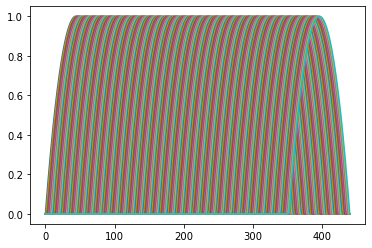

In [5]:
def hann(t, Ac, Tc, sigma):
    x = np.abs(t - Tc)/sigma
    return np.where(x < 0.5, 0.5 * np.cos(np.pi*x), 0)

def gaussian(t, Ac, Tc, sigma):
    t1 = t - Tc
    return Ac * np.exp(-t1 * t1 / (2 * sigma * sigma))

def welch(t, Ac, Tc, sigma):
    x = np.abs(t-Tc)/sigma
    return np.where(x<0.5, 1-4*x*x, 0)

mask = []
window_width = 0.2
for i in np.linspace(window_width/2,1-window_width/2,chirp_reps):
    #window = gaussian(t/chirp_len, 1, i, 0.05)
    #window = hann(t/chirp_len, 1, i, window_width)
    window = welch(t/chirp_len, 1, i, window_width)
    mask.append(window)
    plt.plot(window)
mask = np.concatenate(mask)


# Exponential chirp

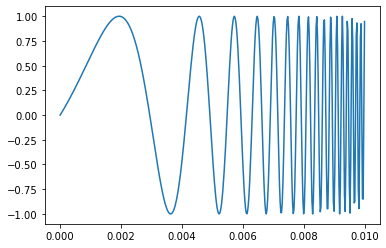

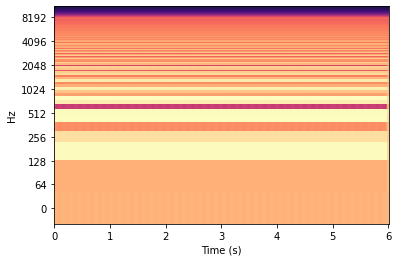

In [6]:
geo_chirp = np.sin(geometric_chirp_phase(t, f0, f1, chirp_len))
plt.plot(t, geo_chirp)
plt.show()
geo_chirp_audio = np.tile(geo_chirp, chirp_reps)
spectrogram(geo_chirp_audio, fs)
ipd.Audio(geo_chirp_audio, rate=fs)

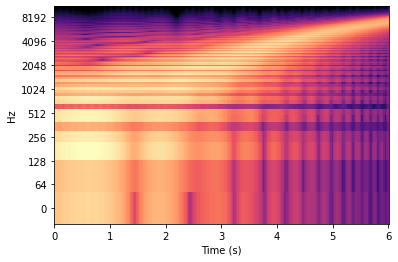

In [7]:
chirp = mask * geo_chirp_audio
spectrogram(chirp, fs)
ipd.Audio(chirp, rate=fs)

# Mel chirp

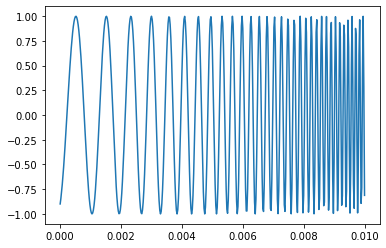

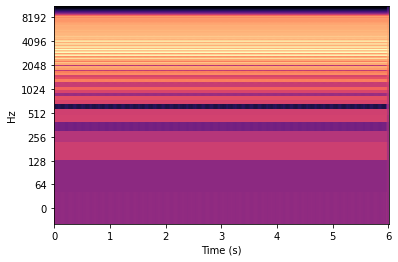

In [8]:
chirp_phase_offset = mel_chirp_phase(0, hz_to_mel(f0), hz_to_mel(f1), 1)
mel_chirp = np.sin(mel_chirp_phase(
    t,
    hz_to_mel(f0),
    hz_to_mel(f1),
    chirp_len,
    phi=-chirp_phase_offset
))
plt.plot(t, mel_chirp)
plt.show()
mel_chirp_audio = np.tile(mel_chirp, chirp_reps)
spectrogram(mel_chirp_audio, fs)
ipd.Audio(mel_chirp_audio, rate=fs)

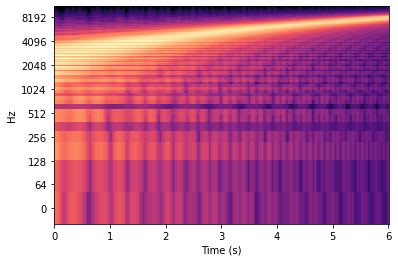

In [9]:
chirp = mask * mel_chirp_audio
spectrogram(chirp, fs)
ipd.Audio(chirp, rate=fs)

# Bark chirp

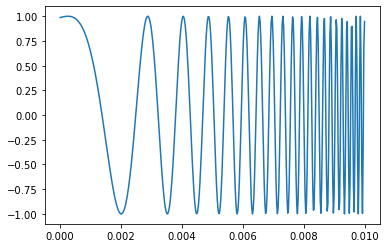

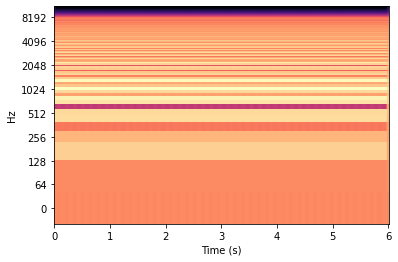

In [10]:
bark_chirp = np.sin(bark_chirp_phase(t, hz_to_bark(f0), hz_to_bark(f1), chirp_len))
plt.plot(t, bark_chirp)
plt.show()
bark_chirp_audio = np.tile(bark_chirp, chirp_reps)
spectrogram(bark_chirp_audio, fs)
ipd.Audio(bark_chirp_audio, rate=fs)

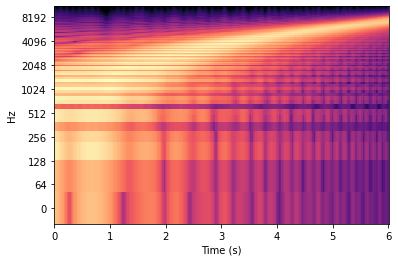

In [11]:
chirp = mask * bark_chirp_audio
spectrogram(chirp, fs)
ipd.Audio(chirp, rate=fs)

# ERB chirp

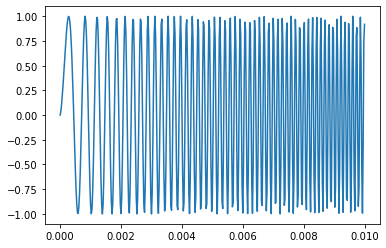

In [12]:
erb_chirp = np.sin(erb_chirp_phase(t, hz_to_erb(f0), hz_to_erb(f1), chirp_len))
plt.plot(t, erb_chirp)
plt.show()
erb_chirp_audio = np.tile(erb_chirp, chirp_reps)
ipd.Audio(erb_chirp_audio, rate=fs)

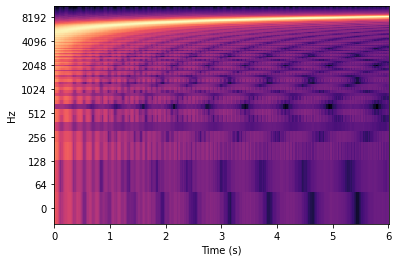

In [13]:
chirp = mask * erb_chirp_audio
spectrogram(chirp, fs)
ipd.Audio(chirp, rate=fs)